In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
# import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def preprocess_h0(ds):
    
#     keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
#                 'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
#                 ## Add budget terms 
#                 # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
#                 # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                 'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                 'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
#                 'wpthlp','wprtp',
#                 # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
#                 # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
#                 # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
#                 # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
#                 # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
#                 # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
#                 # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
#                 ]
    
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR',
#                 'WPRTP2_CLUBB','WPTHLP2_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WPRTPTHLP_CLUBB',
#                 'WP2THLP_CLUBB','WPTHLP2_CLUBB','WPRTPTHLP_ZM_CLUBB',
#                 'WP4_CLUBB','WPRTP2_ZM_CLUBB','WPTHLP2_ZM_CLUBB','WP2RTP_ZM_CLUBB','WP2THLP_ZM_CLUBB',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                # 'PRECZ',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 7
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean().dropna(dim='time')
    dsSel = dsSel.load()

    
        
    return dsSel

In [4]:
def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw',
                      'edmf_precc','edmf_uplh',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    ## Replacing 'missing' updraft values with NaN 
#     dsSel   = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean(dim='time', skipna=True).dropna(dim='time')
    dsSel = dsSel.load()

    
    return dsSel

In [5]:
## Pre-processing to get CLM data

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Set some limits for hours? 
    hrStart = 5
    hrEnd   = 21

    iHoursSCAM  = np.where( (dsSel['time.hour']>=7) & (dsSel['time.hour']<=21) )[0]
    dsSel       = dsSel.isel(time=iHoursSCAM)   
    
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','pft'), QFLX)
    
    ## Resample to 30m means? 
    # print('Resampling to 30m')
#     dsSel = dsSel.load().resample(time="30Min", keep_attrs=True).mean()
    dsSel = dsSel.load()

    
    return dsSel


In [6]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [7]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [8]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    # DS['TKE'].attrs['units']   = 'm2/s2'
    # DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )
    
    # DS['WindMagnitude'].attrs['units']   = 'm/s'
    # DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DS.P0.values/100        # mb 
#     hyam   = np.squeeze(DS.hyam.values)[:]
#     hybm   = np.squeeze(DS.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL','WindMagnitude','CONCLD','QT','GCLDLWP',
#                           'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
#                           'edmf_upbuoy','edmf_updet','edmf_upent',
#                           ## Add budget terms 
                          # 'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                          # 'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
#                           'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
#                           'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
#                           'wpthlp','wprtp','rtp2',
#                           'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          # 'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                          # 'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                          # 'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                          # 'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                          # 'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                          # 'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                          # 'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'
                          ])

    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

    # - - - - - - - - - - - - - - - - - - - - - - - -
      
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()

    ## Compute vertical velocity as m/s rather than Pa/s 
#     w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
#                                np.squeeze(DS['levInterp'].values)*units.hPa, 
#                                np.squeeze(DS['T_interp'].values)*units.K )
#     w_mps_save = np.full([len(DS.time.values), 
#                       len(DS.levInterp.values), 
#                       len(DS.lat.values), 
#                       len(DS.lon.values)], np.nan)
#     w_mps_save[:,:,0,0] = w_mps
    
#     DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
        
    return DS

In [9]:
def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

#     p0mb   = DSctrl.P0.values/100        # mb 
#     hyam   = np.squeeze(DSctrl.hyam.values)[:]
#     hybm   = np.squeeze(DSctrl.hybm.values)[:]
#     pnew64 = p0mb*hyam + p0mb*hybm
#     pnew64 = pnew64[20:-4]
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
#                           'edmf_qtflxup','edmf_thlflxup',
#                           'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           ])
    
#     ## Get averages for ensembles that don't include zeros.... 
#     nTime = len(DS.time.values)

#     for iT in range(nTime):
#         selDS_h2 = scamDS_h2.isel(case=iCase, time=iT, lat=0, lon=0)

#         for iL in range(len(scamDS_h2.ilev.values)):
#             ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
#                                    (np.isfinite(selDS_h2.edmf_upthl.values)==True)
#                                    (selDS_h2.edmf_upa.values!=0) )[0]




    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

## Test option 1 to allocate more plumes to the warmest patch
**04/28/2023**

In [10]:
## Can we figure out which plumes belong to which patch? 
# Ran a case with enhanced atm.log output to help the identification (so it's hacked in for now)
# caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInitNewSfcFiles_Urban25Lake25Grass25irrigcrop25.LASSO_20180605'
#caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_Urban25Lake25Grass25irrigcrop25_L0eq250_treatUrbanLUdifferent_004.LASSO_20180605'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_25UrbanLakeGrassIrrCrop_L0eq250_morePlumesOnWarmestPatch003.LASSO_20180605'

saveDirAtm = '/project/amp/mdfowler/cases/'+caseName+'/run/atm/hist/'
saveDirLnd = '/project/amp/mdfowler/cases/'+caseName+'/run/lnd/hist/'

selFile = saveDirAtm+caseName+'.cam.h0.2018-06-05-18060.nc'
testDS = xr.open_dataset(selFile, decode_times=True)
procDS    = process_camData( testDS )


selFile2 = saveDirAtm+caseName+'.cam.h2.2018-06-05-18060.nc'
# testDS_h2 = xr.open_dataset(selFile2, decode_times=True)
testDS_h2 = xr.open_mfdataset(selFile2,  preprocess=preprocess_h2, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
testDS_h2 = testDS_h2.assign_coords({"nens": np.arange(10)})
procDS_h2 = process_camData_h2( testDS_h2, procDS  )
print('h2 files loaded with mfdataset')

selFileCLM = saveDirLnd+caseName+'.clm2.h1.2018-06-05-18060.nc'
# testDS_CLM = xr.open_dataset(selFileCLM, decode_times=True)
testDS_CLM = xr.open_mfdataset(selFileCLM,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    
selFileCLM2 = saveDirLnd+caseName+'.clm2.h0.2018-06-05-18060.nc'
testDS_h0_CLM = xr.open_dataset(selFileCLM2, decode_times=True)



Beginning interpolation...
Beginning interpolation...
h2 files loaded with mfdataset


In [11]:
# This is the moisture flux used to initiate the plumes -- patchLH in log files 
QFLX = testDS_CLM.QSOIL+testDS_CLM.QVEGE+testDS_CLM.QVEGT

print('itype_veg   itype_col   itypelunit   wtg_cell         label?     QFLX(time=99)\n')

labels = ['C3grass','IrrigCrop','UrbRoof','UrbSunwall','UrbShadewall','UrbImprvRoad','UrbPerviousRd','Lake']

for iTile in range(len(testDS_CLM.pfts1d_itype_veg.values)):
    print('%6i %10i %10i %15.4f %15s %15.4e' % (testDS_CLM.pfts1d_itype_veg.values[iTile], 
          testDS_CLM.pfts1d_itype_col.values[iTile],
          testDS_CLM.pfts1d_itype_lunit.values[iTile],
          testDS_CLM.pfts1d_wtgcell.values[iTile], 
          labels[iTile],
          QFLX.isel(time=99).values[iTile]
                                   ) )



itype_veg   itype_col   itypelunit   wtg_cell         label?     QFLX(time=99)

    13          1          1          0.2500         C3grass      1.0244e-04
    16        216          2          0.2500       IrrigCrop      1.7482e-04
     0         71          8          0.1250         UrbRoof      2.6470e-22
     0         72          8          0.0417      UrbSunwall      0.0000e+00
     0         73          8          0.0417    UrbShadewall      0.0000e+00
     0         74          8          0.0292    UrbImprvRoad      2.6470e-22
     0         75          8          0.0125   UrbPerviousRd      2.5306e-04
     0          5          5          0.2500            Lake      1.1510e-04


In [12]:
plumeLabel = np.full([ len(testDS_h2.time.values), len(testDS_h2.nens.values)], 'SfcAvg')

sigDig = 9

for iT in range(len(testDS_h2.time.values)-1):

    # Sel time QFLX and edmf_uplh 
    this_uplh = testDS_h2.isel(time=iT, ilev=-1, lat=0, lon=0).edmf_uplh.values
    this_qflx = QFLX.isel(time=iT) 

    iGrass = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[0],sigDig))[0]
    iCrop  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[1],sigDig))[0]
    iLake  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[-1],sigDig))[0]

    #Urban mean
    urbMean = np.nansum(this_qflx.values[2:-1]*testDS_CLM.isel(time=iT).pfts1d_wtgcell.values[2:-1])/np.nansum(testDS_CLM.isel(time=iT).pfts1d_wtgcell.values[2:-1])
    iUrban  = np.where(np.around(this_uplh, sigDig) == np.around(urbMean,sigDig))[0] 
    
    ## TODO: For safety, since using a round off digit, should confirm that things aren't being marked as two PFTs 

    plumeLabel[iT, iGrass] = 'C3grass'
    plumeLabel[iT, iCrop]  = 'IrrigCrop'
    plumeLabel[iT, iLake]  = 'Lake'
    plumeLabel[iT, iUrban] = 'Urban'



In [13]:
plumeLabel[0,:]

array(['Lake', 'Lake', 'Lake', 'Lake', 'SfcAvg', 'SfcAvg', 'SfcAvg',
       'SfcAvg', 'SfcAvg', 'SfcAvg'], dtype='<U6')

In [14]:
selCAM = testDS_h2.isel(time=0, ilev=-1, lat=0, lon=0)
selCLM = testDS_CLM.isel(time=0)
selQFLX = QFLX.isel(time=0) 

print('pft TSA = ', selCLM.TSA.values, '\n')
print('pft QFLX = ', selQFLX.values, '\n')
print(selCAM.edmf_uplh.values)


pft TSA =  [300.293   300.2985  301.3532  301.3532  301.3532  301.3532  301.3532
 301.36993] 

pft QFLX =  [9.54156712e-06 8.00216094e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.32631129e-05 1.00772224e-04] 

[0.00010077 0.00010077 0.00010077 0.00010077 0.         0.
 0.         0.         0.         0.        ]


In [87]:
selCLM

<xarray.Dataset>
Dimensions:             (column: 8, gridcell: 1, hist_interval: 2, landunit: 4, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, pft: 8)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
    time                datetime64[ns] 2018-06-06T07:00:59.996567
Dimensions without coordinates: column, gridcell, hist_interval, landunit, lndgrid, pft
Data variables:
    mcdate              int32 20180606
    mcsec               int32 43260
    mdcur               int32 1
    mscur               int32 25200
    nstep               int32 372
    time_bounds         (hist_interval) object 2018-06-06 11:56:00 2018-06-06...
    date_written        |S16 b'04/27/23'
    time_written        |S16 b'14:09:18'
    lon                 (lndgrid) float32 261.6
    lat                 (lndgrid) float32 37.67
    area                (lndgrid) float32 nan
    landfrac            (lndgrid) float32 1.0
    landmask            (lndgrid) float64 1.0
    pftmask             (lndgrid) float64 1.0
    nbedrock            (lndgrid) float64 20.0
    grid1d_lon          (gridcell) float64 261.6
    grid1d_lat          (gridcell) float64 37.67
    grid1d_ixy          (gridcell) float64 1.0
    grid1d_jxy          (gridcell) float64 1.0
    land1d_lon          (landunit) float64 261.6 261.6 261.6 261.6
    land1d_lat          (landunit) float64 37.67 37.67 37.67 37.67
    land1d_ixy          (landunit) float64 1.0 1.0 1.0 1.0
    land1d_jxy          (landunit) float64 1.0 1.0 1.0 1.0
    land1d_gi           (landunit) float64 1.0 1.0 1.0 1.0
    land1d_wtgcell      (landunit) float64 0.25 0.25 0.25 0.25
    land1d_ityplunit    (landunit) float64 1.0 2.0 8.0 5.0
    land1d_active       (landunit) float64 1.0 1.0 1.0 1.0
    cols1d_lon          (column) float64 261.6 261.6 261.6 ... 261.6 261.6 261.6
    cols1d_lat          (column) float64 37.67 37.67 37.67 ... 37.67 37.67 37.67
    cols1d_ixy          (column) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    cols1d_jxy          (column) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    cols1d_gi           (column) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    cols1d_li           (column) float64 1.0 2.0 3.0 3.0 3.0 3.0 3.0 4.0
    cols1d_wtgcell      (column) float64 0.25 0.25 0.125 ... 0.02917 0.0125 0.25
    cols1d_wtlunit      (column) float64 1.0 1.0 0.5 0.1667 ... 0.1167 0.05 1.0
    cols1d_itype_col    (column) float64 1.0 216.0 71.0 72.0 73.0 74.0 75.0 5.0
    cols1d_itype_lunit  (column) float64 1.0 2.0 8.0 8.0 8.0 8.0 8.0 5.0
    cols1d_active       (column) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    pfts1d_lon          (pft) float64 261.6 261.6 261.6 ... 261.6 261.6 261.6
    pfts1d_lat          (pft) float64 37.67 37.67 37.67 ... 37.67 37.67 37.67
    pfts1d_ixy          (pft) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    pfts1d_jxy          (pft) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    pfts1d_gi           (pft) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    pfts1d_li           (pft) float64 1.0 2.0 3.0 3.0 3.0 3.0 3.0 4.0
    pfts1d_ci           (pft) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
    pfts1d_wtgcell      (pft) float64 0.25 0.25 0.125 ... 0.02917 0.0125 0.25
    pfts1d_wtlunit      (pft) float64 1.0 1.0 0.5 0.1667 0.1667 0.1167 0.05 1.0
    pfts1d_wtcol        (pft) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    pfts1d_itype_veg    (pft) float64 13.0 16.0 0.0 0.0 0.0 0.0 0.0 0.0
    pfts1d_itype_col    (pft) float64 1.0 216.0 71.0 72.0 73.0 74.0 75.0 5.0
    pfts1d_itype_lunit  (pft) float64 1.0 2.0 8.0 8.0 8.0 8.0 8.0 5.0
    pfts1d_active       (pft) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    EFLX_LH_TOT         (pft) float32 23.26 19.5 0.0 0.0 0.0 0.0 128.4 249.4
    FSH_TO_COUPLER      (lndgrid) float32 -13.34
    Q2M                 (pf

In [37]:
testDS_h2.time.values[0]

numpy.datetime64('2018-06-06T07:01:00.000000000')

In [40]:
testDS_CLM.time.values[0]

numpy.datetime64('2018-06-06T07:00:59.996567000')

In [46]:
testDS_h2.edmf_upa.isel(time=0,ilev=-1, lat=0, lon=0).values

array([0.00526339, 0.00383932, 0.00270407, 0.0018389 , 0.00120747,
       0.00076554, 0.00046864, 0.000277  , 0.        , 0.        ],
      dtype=float32)

## Test Lopt=6 with potential for area fix

In [6]:
## Current default - total area of updraft plumes in the gridcell is 6.5% 
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_clmInit_edmfTQvarnc_LOPT6.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

ctrlDS = xr.open_dataset(listFiles_h0[0], decode_times=False)
ctrlDS = cesm_correct_time(ctrlDS)
ctrlDS['time'] = ctrlDS.indexes['time'].to_datetimeindex() 


In [7]:
## Potential fix for CLASP updraft area (was 18-19%, since it was 6% per patch; added patch fraction to upa to help...)
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_plumeAreaFix001_LOPT6.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))
listFiles_h2 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h2*'))

testDS = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS = cesm_correct_time(testDS)
testDS['time'] = testDS.indexes['time'].to_datetimeindex() 


In [8]:
## Did area fix work?
testDS_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
print(testDS_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1).sum(dim='nens').values)
## some good news: The fix *did* work; the largest area coverd by updrafts is about 6.5%, and can be ~half that. 
## But the bad news: that did not fix the problem

[0.         0.06461915 0.06461915 0.06461915 0.03123817 0.03123817
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06314278 0.06314278 0.06314278 0.06314278 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.       

In [10]:
testDS_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1,time=1)

<xarray.DataArray 'edmf_upa' (nens: 25)>
array([0.006836, 0.004423, 0.00269 , 0.001537, 0.000825, 0.000417, 0.005929,
       0.003837, 0.002333, 0.001333, 0.000716, 0.000361, 0.007178, 0.00586 ,
       0.00471 , 0.003727, 0.002903, 0.002227, 0.001682, 0.00125 , 0.000915,
       0.000659, 0.000468, 0.000327, 0.001476], dtype=float32)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
    ilev     float64 1e+03
    time     float64 0.01042
Dimensions without coordinates: nens
Attributes:
    mdims:      [2 4]
    units:      fraction
    long_name:  Plume updraft area fraction (EDMF)

In [14]:
testDS_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1,time=1)/testDS_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1,time=1).sum(dim='nens')

<xarray.DataArray 'edmf_upa' (nens: 25)>
array([0.10578417, 0.06845438, 0.04162727, 0.02378759, 0.01277374,
       0.00644585, 0.09175728, 0.05937739, 0.03610753, 0.02063337,
       0.01107995, 0.00559114, 0.11107505, 0.09068077, 0.07288477,
       0.05767417, 0.04493129, 0.03446191, 0.02602273, 0.01934591,
       0.01415952, 0.01020307, 0.00723829, 0.0050555 , 0.02284737],
      dtype=float32)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
    ilev     float64 1e+03
    time     float64 0.01042
Dimensions without coordinates: nens

In [9]:
## Explore importance of area fraction change -- what if we make area covered LARGER in CLUBB-MF?
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_clmInit_LOPT6_pwminEQ1p0.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))
listFiles_h2 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h2*'))

ctrlDS_pwminEq1 = xr.open_dataset(listFiles_h0[0], decode_times=False)
ctrlDS_pwminEq1 = cesm_correct_time(ctrlDS_pwminEq1)
ctrlDS_pwminEq1['time'] = ctrlDS_pwminEq1.indexes['time'].to_datetimeindex() 

ctrlDS_pwminEq1_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
print(ctrlDS_pwminEq1_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1).sum(dim='nens').values)


[0.         0.15730536 0.15730536 0.15730536 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536 0.15730536
 0.15730536 0.15730536 0.15730536 0.15730536 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

In [10]:
## Explore importance of area fraction change -- what if we make area covered SMALLER in CLUBB-MF?
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_clmInit_LOPT6_pwminEQ2p0.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))
listFiles_h2 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h2*'))

ctrlDS_pwminEq2 = xr.open_dataset(listFiles_h0[0], decode_times=False)
ctrlDS_pwminEq2 = cesm_correct_time(ctrlDS_pwminEq2)
ctrlDS_pwminEq2['time'] = ctrlDS_pwminEq2.indexes['time'].to_datetimeindex() 

ctrlDS_pwminEq2_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
print(ctrlDS_pwminEq2_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1).sum(dim='nens').values)


[0.         0.02140023 0.02140023 0.02140023 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023 0.02140023
 0.02140023 0.02140023 0.02140023 0.02140023 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

In [11]:
## Proposed fix for computing precip: 
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_plumeAreaFix001_PRECTfix002_LOPT6.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

testDS_fix1 = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS_fix1 = cesm_correct_time(testDS_fix1)
testDS_fix1['time'] = testDS_fix1.indexes['time'].to_datetimeindex() 




In [32]:
## Proposed fix for computing precip with 10 updraft plumes (not 25): 
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_plumeAreaFix001_PRECTfix002_LOPT6_nupEq10.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

testDS_fix1_nup10 = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS_fix1_nup10 = cesm_correct_time(testDS_fix1_nup10)
testDS_fix1_nup10['time'] = testDS_fix1_nup10.indexes['time'].to_datetimeindex() 




In [21]:
## Proposed fix for computing precip on L0=150: 
runDir   = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_latestMergeMar15_addTQvar_L0eq150_testPRECTfix002.003.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))
listFiles_h2 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h2*'))

testDS_fix1_L150 = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS_fix1_L150 = cesm_correct_time(testDS_fix1_L150)
testDS_fix1_L150['time'] = testDS_fix1_L150.indexes['time'].to_datetimeindex() 

testDS_fix1_L150_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
print(testDS_fix1_L150_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1).sum(dim='nens').values)



[0.         0.06314278 0.06314278 0.06314278 0.06314278 0.06314278
 0.06314278 0.06314278 0.06314278 0.06314278 0.03123817 0.03123817
 0.03123817 0.03123817 0.03123817 0.01672816 0.01672816 0.01672816
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06314278 0.06314278 0.06314278 0.06314278
 0.06314278 0.06314278 0.06314278 0.06314278 0.06314278 0.06314278
 0.06314278 0.06

In [22]:
## Proposed fix for computing precip on L0=150 with 25 plumes (not 10): 
runDir   = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_latestMergeMar15_addTQvar_L0eq150_nupEq25_testPRECTfix002.003.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))
listFiles_h2 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h2*'))

testDS_fix1_L150_nup25 = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS_fix1_L150_nup25 = cesm_correct_time(testDS_fix1_L150_nup25)
testDS_fix1_L150_nup25['time'] = testDS_fix1_L150_nup25.indexes['time'].to_datetimeindex() 

testDS_fix1_L150_nup25_h2 = xr.open_dataset(listFiles_h2[0], decode_times=False)
print(testDS_fix1_L150_nup25_h2.edmf_upa.isel(lat=0,lon=0,ilev=-1).sum(dim='nens').values)



[0.         0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06314278 0.03123817 0.03123817
 0.03123817 0.03123817 0.03123817 0.01672816 0.01672816 0.01672816
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915 0.06461915
 0.06461915 0.06

Okay now plot that:

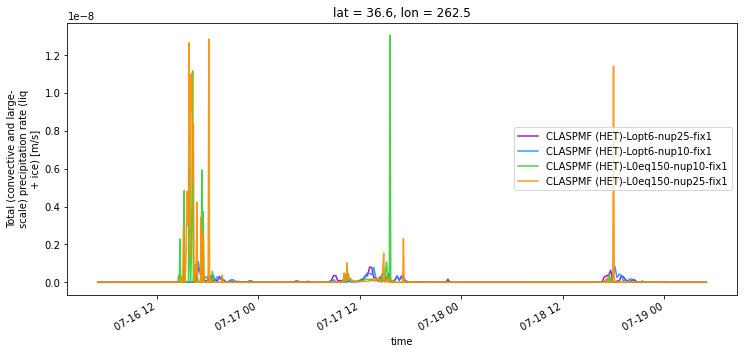

In [38]:
fig,axs = plt.subplots(1,1,figsize=(12,5))
# ctrlDS.PRECT.plot(color='k',linewidth=2, label='CLUBBMF (HOM)-Lopt6, pwmin=1.5')
# ctrlDS_pwminEq1.PRECT.plot(color='blue',linewidth=2, label='CLUBBMF (HOM)-Lopt6, pwmin=1.0')
# ctrlDS_pwminEq2.PRECT.plot(color='mediumturquoise',linewidth=2, label='CLUBBMF (HOM)-Lopt6, pwmin=2.0')


# testDS.PRECT.plot(color='r', alpha=0.75, label='CLASPMF (HET)-Lopt6')
testDS_fix1.PRECT.plot(color='darkviolet', linestyle='-', alpha=0.9, label='CLASPMF (HET)-Lopt6-nup25-fix1')
testDS_fix1_nup10.PRECT.plot(color='dodgerblue', linestyle='-', alpha=0.9, label='CLASPMF (HET)-Lopt6-nup10-fix1')
testDS_fix1_L150.PRECT.plot(color='limegreen', linestyle='-', alpha=0.9, label='CLASPMF (HET)-L0eq150-nup10-fix1')
testDS_fix1_L150_nup25.PRECT.plot(color='darkorange', linestyle='-', alpha=0.9, label='CLASPMF (HET)-L0eq150-nup25-fix1')


plt.legend()


## Quick test: Lopt6 giving negative PRECT??

In [62]:
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_clmInit_edmfTQvarnc_LOPT6.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

ctrlDS = xr.open_dataset(listFiles_h0[0], decode_times=False)
ctrlDS = cesm_correct_time(ctrlDS)
ctrlDS['time'] = ctrlDS.indexes['time'].to_datetimeindex() 


In [63]:
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_edmfTQvarnc_LOPT6.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

testDS = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS = cesm_correct_time(testDS)
testDS['time'] = testDS.indexes['time'].to_datetimeindex() 


In [64]:
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_mfMergeMar_clmInit_edmfTQvarnc.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

testDS_L0 = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS_L0 = cesm_correct_time(testDS_L0)
testDS_L0['time'] = testDS_L0.indexes['time'].to_datetimeindex() 


In [65]:
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_edmfTQvarnc_L0eq150.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

testDS_L0eq150 = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS_L0eq150 = cesm_correct_time(testDS_L0eq150)
testDS_L0eq150['time'] = testDS_L0eq150.indexes['time'].to_datetimeindex() 


In [66]:
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_clmInit_edmfTQvarnc_L0eq150.LASSO_20170716'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

ctrlDS_L0eq150 = xr.open_dataset(listFiles_h0[0], decode_times=False)
ctrlDS_L0eq150 = cesm_correct_time(ctrlDS_L0eq150)
ctrlDS_L0eq150['time'] = ctrlDS_L0eq150.indexes['time'].to_datetimeindex() 


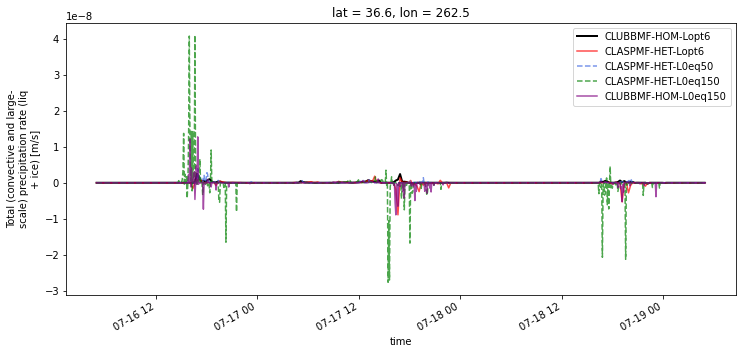

In [73]:
fig,axs = plt.subplots(1,1,figsize=(12,5))
ctrlDS.PRECT.plot(color='k',linewidth=2)
testDS.PRECT.plot(color='r',alpha=0.7)
testDS_L0.PRECT.plot(color='royalblue',linestyle='--',alpha=0.7)
testDS_L0eq150.PRECT.plot(color='g',linestyle='--',alpha=0.7)
ctrlDS_L0eq150.PRECT.plot(color='purple',alpha=0.7)

plt.legend(['CLUBBMF-HOM-Lopt6','CLASPMF-HET-Lopt6','CLASPMF-HET-L0eq50', 'CLASPMF-HET-L0eq150','CLUBBMF-HOM-L0eq150'])

# plt.xlim(ctrlDS.time.values[230],ctrlDS.time.values[-12])


In [23]:
ctrlDS.PRECT.values[np.where(ctrlDS.PRECT.values<0)]

array([-1.26301705e-10, -4.90173223e-12, -1.58004287e-11, -1.10024385e-11,
       -2.75578088e-10, -5.67155697e-11], dtype=float32)

### ARM 97 test

In [52]:
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_clmInit_latestMergeMar15_addTQvar_L0eq150.ARM97'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

testDS = xr.open_dataset(listFiles_h0[0], decode_times=False)
testDS = cesm_correct_time(testDS)
testDS['time'] = testDS.indexes['time'].to_datetimeindex() 


In [53]:
runDir = '/project/amp/mdfowler/cases/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_clmInit_latestMergeMar15_addTQvar_L0eq150.ARM97'

listFiles_h0 = np.sort(glob.glob(runDir+caseName+'/run/atm/hist/*cam.h0*'))

ctrlDS = xr.open_dataset(listFiles_h0[0], decode_times=False)
ctrlDS = cesm_correct_time(ctrlDS)
ctrlDS['time'] = ctrlDS.indexes['time'].to_datetimeindex() 


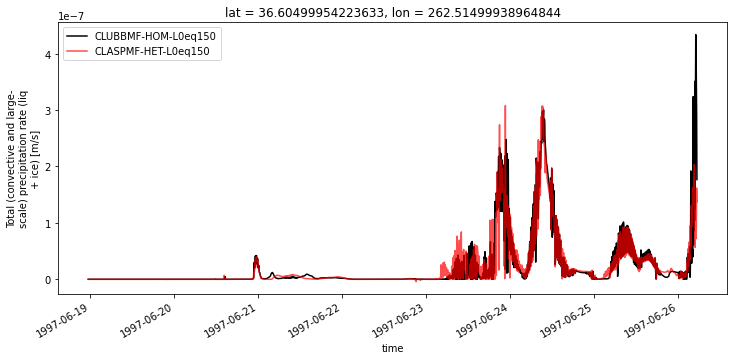

In [57]:
fig,axs = plt.subplots(1,1,figsize=(12,5))
ctrlDS.PRECT.plot(color='k')
testDS.PRECT.plot(color='r',alpha=0.7)
plt.legend([ 'CLUBBMF-HOM-L0eq150', 'CLASPMF-HET-L0eq150'])

# plt.xlim(ctrlDS.time.values[230],ctrlDS.time.values[-12])


In [55]:
np.where(ctrlDS.PRECT.values<0)

(array([ 283, 1139, 1142, 1144, 1145, 1159]),
 array([0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0]))

In [56]:
np.where(testDS.PRECT.values<0)

(array([ 273, 1120, 1124, 1125, 1127, 1131, 1132, 1365]),
 array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0]))

## Read data

In [6]:
archiveDir = '/scratch/cluster/mdfowler/testDebug/'

# caseCTRL   = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_bigCodeMods01.LASSO_20170923'
# caseCLSP   = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_bigCodeMods01.LASSO_20170923'
caseCTRL   = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxFALSE_bigCodeMods01.LASSO_20180605'
caseCLSP   = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxFALSE_bigCodeMods01.LASSO_20180605'

## CTRL case
listFilesCTRL_h0 = np.sort(glob.glob(archiveDir+caseCTRL+'*cam.h0*'))
listFilesCTRL_h1 = np.sort(glob.glob(archiveDir+caseCTRL+'*cam.h1*'))
listFilesCTRL_h2 = np.sort(glob.glob(archiveDir+caseCTRL+'*cam.h2*'))
listFilesCTRL_clm = np.sort(glob.glob(archiveDir+caseCTRL+'*clm2.h0*'))

dsh0_ctrl = xr.open_dataset(listFilesCTRL_h0[0], decode_times=True)
dsh1_ctrl = xr.open_dataset(listFilesCTRL_h1[0], decode_times=True)
dsh1_ctrl = xr.open_dataset(listFilesCTRL_h2[0], decode_times=True)

dsCLM_ctrl = xr.open_dataset(listFilesCTRL_clm[0], decode_times=True)

caseCTRL = xr.merge([dsh0_ctrl, dsh1_ctrl, dsh1_ctrl],compat='minimal')


## CLASP case
listFilesCLSP_h0 = np.sort(glob.glob(archiveDir+caseCLSP+'*cam.h0*'))
listFilesCLSP_h1 = np.sort(glob.glob(archiveDir+caseCLSP+'*cam.h1*'))
listFilesCLSP_h2 = np.sort(glob.glob(archiveDir+caseCLSP+'*cam.h2*'))
listFilesCLSP_clm = np.sort(glob.glob(archiveDir+caseCLSP+'*clm2.h0*'))


dsh0_clsp = xr.open_dataset(listFilesCLSP_h0[0], decode_times=True)
dsh1_clsp = xr.open_dataset(listFilesCLSP_h1[0], decode_times=True)
dsh1_clsp = xr.open_dataset(listFilesCLSP_h2[0], decode_times=True)

dsCLM_clsp = xr.open_dataset(listFilesCLSP_clm[0], decode_times=True)

caseCLSP = xr.merge([dsh0_clsp, dsh1_clsp, dsh1_clsp],compat='minimal')

## Get more useful time index
caseCTRL['time'] = caseCTRL.indexes['time'].to_datetimeindex() 
caseCLSP['time'] = caseCLSP.indexes['time'].to_datetimeindex() 
dsCLM_ctrl['time'] = caseCTRL.time.values
dsCLM_clsp['time'] = caseCLSP.time.values


## Make nens a dimension
caseCTRL = caseCTRL.assign_coords({"nens": np.arange(10)})
caseCLSP = caseCLSP.assign_coords({"nens": np.arange(10)})

print('Hey cool! You read in all your data!')

Hey cool! You read in all your data!


Text(0.5, 1.0, 'TSA')

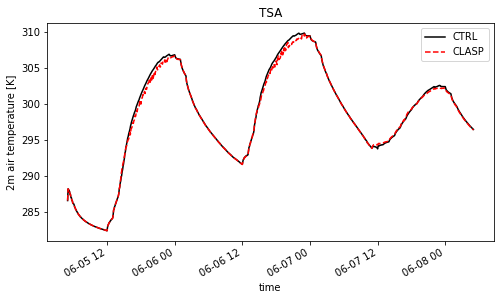

In [7]:
fig,axs=plt.subplots(1,1,figsize=(8,4))

varSel = 'TSA'

dsCLM_ctrl[varSel].plot(color='k',label='CTRL')
dsCLM_clsp[varSel].plot(color='r',linestyle='--',label='CLASP')

axs.legend()
axs.set_title(varSel)

Text(0.5, 1.0, 'SHFLX')

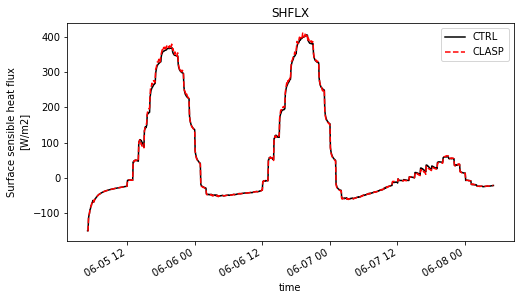

In [9]:
fig,axs=plt.subplots(1,1,figsize=(8,4))

varSel = 'SHFLX'

caseCTRL[varSel].plot(color='k',label='CTRL')
caseCLSP[varSel].plot(color='r',linestyle='--',label='CLASP')

axs.legend()
axs.set_title(varSel)

In [7]:
case_h0 = xr.open_mfdataset(listFilesCLSP_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h0 files loaded')


case_h2 = xr.open_mfdataset(listFilesCLSP_h2,  preprocess=preprocess_h2, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h2 files loaded with mfdataset')



h0 files loaded
h2 files loaded with mfdataset


In [29]:
case_h2.isel(time=20,lat=0,lon=0).edmf_upthl

<xarray.DataArray 'edmf_upthl' (nens: 10, ilev: 59)>
array([[      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan, 296.8594 ],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan, 296.98492],
...
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan, 297.18842, 297.13135],
       [      nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan, 297.25555, 297.21506]],
      dtype=float32)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
    time     datetime64[ns] 2018-06-06T08:43:30
Dimensions without coordinates: nens
Attributes:
    mdims:      [2 4]
    units:      K
    long_name:  Plume updraft liquid potential temperature (EDMF)

In [31]:
DS = case_h2.isel(time=30)
pnew64 = np.arange(200.0,980.0,10.0) 
DS = DS.assign_coords({"levInterp": pnew64})

DSctrl = case_h0.isel(time=20)

varName = 'edmf_upw'

# interpVar_real = interpolateToPressure_v2_h2(DS, case_h0.isel(time=20), 'edmf_upthl', pnew64)
p0mb = DSctrl.P0.values/100        # mb 
print('p0mb = ',p0mb)

# Pull out hya/hyb profiles 
hyam = np.squeeze(DSctrl.hyam.values)[:]
hybm = np.squeeze(DSctrl.hybm.values)[:]
hyai = np.squeeze(DSctrl.hyai.values)[:]
hybi = np.squeeze(DSctrl.hybi.values)[:]

ptest = p0mb*hyam + p0mb*hybm

# Surface pressure with time dimension
PS   = DSctrl.PS.values              # Pa 
print('PS = ', PS)

if np.shape(DS[varName].values)[0]==len(DS.nens.values):
    varInterp = np.full([len(DS.nens.values) ,
                         len(ptest), len(DS.lat.values), len(DS.lon.values)], np.nan)
    
    varInterp64 = np.full([len(DS.nens.values) ,
                         len(pnew64), len(DS.lat.values), len(DS.lon.values)], np.nan)
    
    varInterpFalse = np.full([len(DS.nens.values) ,
                         len(ptest), len(DS.lat.values), len(DS.lon.values)], np.nan)

    for iEns in range(len(DS.nens.values)):
        varInterp[iEns,:,:,:]   = Ngl.vinth2p(DS[varName].values[iEns,:,:,:],hyai,hybi,ptest,PS,1,p0mb,1,True)
        varInterp64[iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[iEns,:,:,:],hyai,hybi,pnew64,PS,1,p0mb,1,True)
        varInterpFalse[iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[iEns,:,:,:],hyai,hybi,ptest,PS,1,p0mb,1,False)



p0mb =  1000.0
PS =  [[96799.16]]


In [33]:
print(ptest[-1], '   ', pnew64[-1])

997.5277256106473     970.0


In [23]:
varInterp[:,-1,0,0]

array([ 0.46711958, -0.97206159, -0.72923866, -1.04880635, -0.80465895,
       -3.29444124,  0.55741898, -3.87194257, -0.95311762,  1.65679928])

In [24]:
varInterpFalse[:,-1,0,0]

array([1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30,
       1.e+30, 1.e+30])

In [32]:
varInterp64[:,-1,0,0]

array([0.88388069, 1.02947941, 1.28945307, 0.84019286, 1.22139906,
       0.60977157, 1.02329365, 0.87369866, 1.22377497, 1.55284588])

In [28]:
varInterpFalse2[:,-1,0,0]

array([1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30, 1.e+30,
       1.e+30, 1.e+30])

In [ ]:
DSctrl = case_h0.isel(time=20)

varName = 'edmf_upthl'

# interpVar_real = interpolateToPressure_v2_h2(DS, case_h0.isel(time=20), 'edmf_upthl', pnew64)
p0mb = DSctrl.P0.values/100        # mb 
print('p0mb = ',p0mb)

ptest = p0mb*hyam + p0mb*hybm

ptest

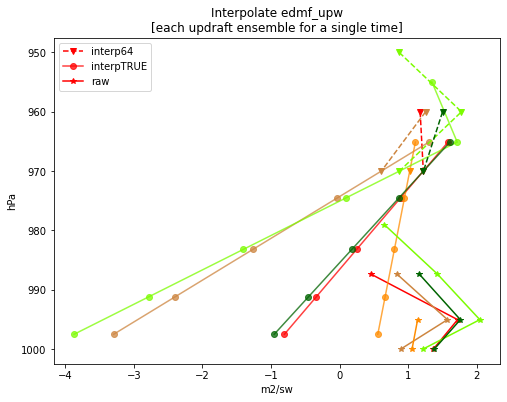

In [45]:
fig,axs = plt.subplots(1,1,figsize=(8,6))
colorList = ['red','peru','darkorange','lawngreen','darkgreen','teal','cyan','blueviolet','magenta','lightpink']

for iEns in range(5):
    axs.plot(varInterp64[iEns+4,:,0,0], pnew64,'--v', color=colorList[iEns])
    axs.plot(varInterp[iEns+4,:,0,0], ptest,'-o', color=colorList[iEns], alpha=0.75)
    axs.plot(DS[varName].values[iEns+4,:,0,0], DS.ilev.values,'-*',color=colorList[iEns])

axs.legend(['interp64','interpTRUE','raw'])
axs.invert_yaxis()
axs.set_title('Interpolate edmf_upw\n[each updraft ensemble for a single time]')
axs.set_ylabel('hPa')
axs.set_xlabel('m2/sw')

plt.show()


In [ ]:
def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [ ]:
def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw','edmf_precc',
                           ])
    
#     ## Get averages for ensembles that don't include zeros.... 
#     nTime = len(DS.time.values)

#     for iT in range(nTime):
#         selDS_h2 = scamDS_h2.isel(case=iCase, time=iT, lat=0, lon=0)

#         for iL in range(len(scamDS_h2.ilev.values)):
#             ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
#                                    (np.isfinite(selDS_h2.edmf_upthl.values)==True)
#                                    (selDS_h2.edmf_upa.values!=0) )[0]




    for iVar in range(len(varSels)): 
        # varUnits = DS[varSels[iVar]].units
        # varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        # DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        # DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
#     ## Resample to 30m means? 
#     DS = DS.resample(time="30Min").mean()
        
    return DS

In [4]:
## Get averages for ensembles that don't include zeros.... 
nTime = len(caseCLSP.time.values)
nLevs = len(caseCLSP.ilev.values)

validPlumes = np.full([nTime, nLevs], np.nan)

for iT in range(nTime):
    selDS_h2 = caseCLSP.isel(time=iT, lat=0, lon=0)

    for iL in range(nLevs):
        ivalPlumes = np.where( (selDS_h2.edmf_upthl.values!=0) &   # [ens,ilev]
                               (np.isfinite(selDS_h2.edmf_upthl.values)) & 
                               (selDS_h2.edmf_upa.values!=0) )[0]
        
        validPlumes[iT,iL] = len(ivalPlumes)

        



In [4]:
testDS = caseCLSP.isel(time=806)

In [8]:
testDS.edmf_upthl.isel(lat=0,lon=0)

<xarray.DataArray 'edmf_upthl' (nens: 10, ilev: 59)>
array([[  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     , 304.775  , 304.75494, 304.75494],
       [  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     , 304.77893, 304.76105, 304.77277],
...
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     , 304.69254],
       [  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     , 304.69254]],
      dtype=float32)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
    time     datetime64[ns] 2018-06-08T00:11:00
  * nens     (nens) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    mdims:      [2 4]
    units:      K
    long_name:  Plume updraft liquid potential temperature (EDMF)

In [81]:
edmf_meanUPW   = case_h2.edmf_upw.mean(dim='nens')    # m/s
edmf_meanUPTHL = case_h2.edmf_upthl.mean(dim='nens')  # K

In [84]:
np.shape(edmf_meanUPW)

(180, 59, 1, 1)

### Diving into some sanity checking

In [7]:
caseCLSP_sfc.edmf_upthl.isel(time=5).values

caseCLSP_sfc.edmf_upa.isel(time=5)


<xarray.DataArray 'edmf_upa' (nens: 10)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
    ilev     float64 1e+03
    time     datetime64[ns] 2018-06-05T05:26:00
  * nens     (nens) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    mdims:      [2 4]
    units:      fraction
    long_name:  Plume updraft area fraction (EDMF)

In [22]:
nt = len(caseCLSP.time.values)

caseCLSP_sfc = caseCLSP.isel(lat=0,lon=0,ilev=-1)

print('iTime    valPlumes')
for it in range(nt):
    nValEns = np.where( (caseCLSP_sfc.edmf_upthl.isel(time=it).values!=0) & 
                        (caseCLSP_sfc.edmf_upa.isel(time=it).values!=0) )[0]
    
    print('%3i  %10i' % (it, len(nValEns)))
    print(caseCLSP_sfc.isel(time=it).time.values)
    

iTime    valPlumes
  0           0
2018-06-05T05:01:00.000000000
  1           0
2018-06-05T05:06:00.000000000
  2           0
2018-06-05T05:11:00.000000000
  3           0
2018-06-05T05:16:00.000000000
  4           0
2018-06-05T05:21:00.000000000
  5           0
2018-06-05T05:26:00.000000000
  6           0
2018-06-05T05:31:00.000000000
  7           0
2018-06-05T05:36:00.000000000
  8           0
2018-06-05T05:41:00.000000000
  9           0
2018-06-05T05:46:00.000000000
 10           0
2018-06-05T05:51:00.000000000
 11           0
2018-06-05T05:56:00.000000000
 12           0
2018-06-05T06:01:00.000000000
 13           0
2018-06-05T06:06:00.000000000
 14           0
2018-06-05T06:11:00.000000000
 15           0
2018-06-05T06:16:00.000000000
 16           0
2018-06-05T06:21:00.000000000
 17           0
2018-06-05T06:26:00.000000000
 18           0
2018-06-05T06:31:00.000000000
 19           0
2018-06-05T06:36:00.000000000
 20           0
2018-06-05T06:41:00.000000000
 21           0

2018-06-05T22:41:00.000000000
213          10
2018-06-05T22:46:00.000000000
214          10
2018-06-05T22:51:00.000000000
215          10
2018-06-05T22:56:00.000000000
216          10
2018-06-05T23:01:00.000000000
217          10
2018-06-05T23:06:00.000000000
218          10
2018-06-05T23:11:00.000000000
219          10
2018-06-05T23:16:00.000000000
220          10
2018-06-05T23:21:00.000000000
221          10
2018-06-05T23:26:00.000000000
222          10
2018-06-05T23:31:00.000000000
223          10
2018-06-05T23:36:00.000000000
224          10
2018-06-05T23:41:00.000000000
225          10
2018-06-05T23:46:00.000000000
226          10
2018-06-05T23:51:00.000000000
227          10
2018-06-05T23:56:00.000000000
228          10
2018-06-06T00:01:00.000000000
229          10
2018-06-06T00:06:00.000000000
230          10
2018-06-06T00:11:00.000000000
231          10
2018-06-06T00:16:00.000000000
232          10
2018-06-06T00:21:00.000000000
233          10
2018-06-06T00:26:00.000000000
234 

409          10
2018-06-06T15:06:00.000000000
410          10
2018-06-06T15:11:00.000000000
411          10
2018-06-06T15:16:00.000000000
412          10
2018-06-06T15:21:00.000000000
413          10
2018-06-06T15:26:00.000000000
414          10
2018-06-06T15:31:00.000000000
415          10
2018-06-06T15:36:00.000000000
416          10
2018-06-06T15:41:00.000000000
417          10
2018-06-06T15:46:00.000000000
418          10
2018-06-06T15:51:00.000000000
419          10
2018-06-06T15:56:00.000000000
420          10
2018-06-06T16:01:00.000000000
421          10
2018-06-06T16:06:00.000000000
422          10
2018-06-06T16:11:00.000000000
423          10
2018-06-06T16:16:00.000000000
424          10
2018-06-06T16:21:00.000000000
425          10
2018-06-06T16:26:00.000000000
426          10
2018-06-06T16:31:00.000000000
427          10
2018-06-06T16:36:00.000000000
428          10
2018-06-06T16:41:00.000000000
429          10
2018-06-06T16:46:00.000000000
430          10
2018-06-06T16:51:0

2018-06-07T07:06:00.000000000
602           0
2018-06-07T07:11:00.000000000
603           0
2018-06-07T07:16:00.000000000
604           0
2018-06-07T07:21:00.000000000
605           0
2018-06-07T07:26:00.000000000
606           0
2018-06-07T07:31:00.000000000
607           0
2018-06-07T07:36:00.000000000
608           0
2018-06-07T07:41:00.000000000
609           0
2018-06-07T07:46:00.000000000
610           0
2018-06-07T07:51:00.000000000
611           0
2018-06-07T07:56:00.000000000
612           0
2018-06-07T08:01:00.000000000
613           0
2018-06-07T08:06:00.000000000
614           0
2018-06-07T08:11:00.000000000
615           0
2018-06-07T08:16:00.000000000
616           0
2018-06-07T08:21:00.000000000
617           0
2018-06-07T08:26:00.000000000
618           0
2018-06-07T08:31:00.000000000
619           0
2018-06-07T08:36:00.000000000
620           0
2018-06-07T08:41:00.000000000
621           0
2018-06-07T08:46:00.000000000
622           0
2018-06-07T08:51:00.000000000
623 

2018-06-07T22:51:00.000000000
791          10
2018-06-07T22:56:00.000000000
792          10
2018-06-07T23:01:00.000000000
793          10
2018-06-07T23:06:00.000000000
794          10
2018-06-07T23:11:00.000000000
795          10
2018-06-07T23:16:00.000000000
796          10
2018-06-07T23:21:00.000000000
797          10
2018-06-07T23:26:00.000000000
798          10
2018-06-07T23:31:00.000000000
799          10
2018-06-07T23:36:00.000000000
800          10
2018-06-07T23:41:00.000000000
801          10
2018-06-07T23:46:00.000000000
802          10
2018-06-07T23:51:00.000000000
803          10
2018-06-07T23:56:00.000000000
804          10
2018-06-08T00:01:00.000000000
805          10
2018-06-08T00:06:00.000000000
806           5
2018-06-08T00:11:00.000000000
807           5
2018-06-08T00:16:00.000000000
808           5
2018-06-08T00:21:00.000000000
809           5
2018-06-08T00:26:00.000000000
810           5
2018-06-08T00:31:00.000000000
811           5
2018-06-08T00:36:00.000000000
812 

In [9]:
caseCLSP.edmf_upthl


<xarray.DataArray 'edmf_upthl' (time: 865, nens: 10, ilev: 59, lat: 1, lon: 1)>
array([[[[[  0.     ]],

         [[  0.     ]],

         [[  0.     ]],

         ...,

         [[  0.     ]],

         [[  0.     ]],

         [[  0.     ]]],


        [[[  0.     ]],

         [[  0.     ]],

         [[  0.     ]],
...
         [[  0.     ]],

         [[  0.     ]],

         [[299.07492]]],


        [[[  0.     ]],

         [[  0.     ]],

         [[  0.     ]],

         ...,

         [[  0.     ]],

         [[  0.     ]],

         [[299.07492]]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.6
  * lon      (lon) float64 262.5
  * ilev     (ilev) float64 2.055 3.98 6.909 11.27 ... 979.0 987.4 995.1 1e+03
  * time     (time) datetime64[ns] 2018-06-05T05:01:00 ... 2018-06-08T05:01:00
  * nens     (nens) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    mdims:      [2 4]
    units:      K
    long_name:  Plume updraft liquid potential temperature (EDMF)

### Back to regularly scheduled programming

In [3]:
## Select the second simulated day for analysis 
iTimeStart_day2  = np.where( (caseCTRL.time.values >= (caseCTRL.time.values[0] + np.timedelta64(1,'D'))) & 
                             (caseCTRL.time.values <= (caseCTRL.time.values[0] + np.timedelta64(2,'D'))))[0]
caseCTRL_Sel      = caseCTRL.isel(time=np.sort(iTimeStart_day2))
clmCTRL_Sel    = dsCLM_ctrl.isel(time=np.sort(iTimeStart_day2))

# Compute local time 
localTimes  = caseCTRL_Sel['time'].values - np.timedelta64(5,'h')
dsCtrl_Sel  = caseCTRL_Sel.assign_coords({"time": localTimes})
dsCtrlCLM_Sel = clmCTRL_Sel.assign_coords({"time": localTimes})

# CLASP case

## Select the second simulated day for analysis 
iTimeStart_day2  = np.where( (caseCLSP.time.values >= (caseCLSP.time.values[0] + np.timedelta64(1,'D'))) & 
                             (caseCLSP.time.values <= (caseCLSP.time.values[0] + np.timedelta64(2,'D'))))[0]
caseCLSP_Sel      = caseCLSP.isel(time=np.sort(iTimeStart_day2))
clmCTRL_Sel       = dsCLM_clsp.isel(time=np.sort(iTimeStart_day2))

# Compute local time 
localTimes  = caseCLSP_Sel['time'].values - np.timedelta64(5,'h')
dsCLSP_Sel  = caseCLSP_Sel.assign_coords({"time": localTimes})
dsClspCLM_Sel = clmCTRL_Sel.assign_coords({"time": localTimes})


In [15]:
dsCtrl_Sel.TGCLDLWP.units

'kg/m2'

Text(0.5, 0, 'Hour (local)')

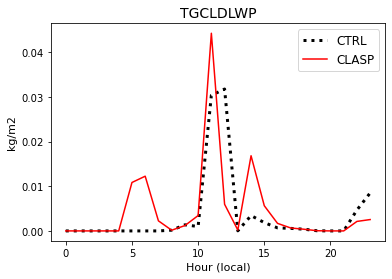

In [17]:
fig,axs=plt.subplots(1,1,figsize=(6,4))

varSel = 'TGCLDLWP'

dsCtrl_Sel.isel(lon=0,lat=0)[varSel].groupby('time.hour').mean(dim='time').plot(color='k',linestyle=':',linewidth=3,label='CTRL')
dsCLSP_Sel.isel(lon=0,lat=0)[varSel].groupby('time.hour').mean(dim='time').plot(color='r',linestyle='-',label='CLASP')

axs.legend(fontsize=12)
axs.set_title(varSel,fontsize=14)
axs.set_ylabel(dsCtrl_Sel[varSel].units, fontsize=11)
axs.set_xlabel('Hour (local)', fontsize=11)

Text(0.5, 1.0, 'TSA')

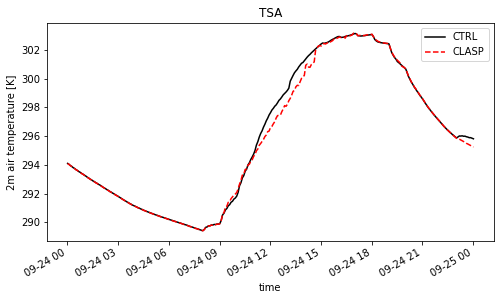

In [31]:
fig,axs=plt.subplots(1,1,figsize=(8,4))

varSel = 'TSA'

dsCtrlCLM_Sel[varSel].plot(color='k',label='CTRL')
dsClspCLM_Sel[varSel].plot(color='r',linestyle='--',label='CLASP')

axs.legend()
axs.set_title(varSel)

In [25]:
dsClspCLM_Sel

<xarray.Dataset>
Dimensions:                        (cft: 2, glc_nec: 10, hist_interval: 2, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, ltype: 9, natpft: 15, nvegwcs: 4, time: 289)
Coordinates:
  * levgrnd                        (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                         (levsoi) float32 0.01 0.04 0.09 ... 6.94 8.03
  * levlak                         (levlak) float32 0.05 0.6 2.1 ... 34.33 44.78
  * levdcmp                        (levdcmp) float32 1.0
  * time                           (time) datetime64[ns] 2017-09-24T00:01:00 ...
Dimensions without coordinates: cft, glc_nec, hist_interval, lndgrid, ltype, natpft, nvegwcs
Data variables:
    mcdate                         (time) int32 ...
    mcsec                          (time) int32 ...
    mdcur                          (time) int32 ...
    mscur                          (time) int32 ...
    nstep                          (time) int32 ...
    time_bounds                    (time, hist_interval) object ...
    date_written                   (time) |S16 ...
    time_written                   (time) |S16 ...
    lon                            (lndgrid) float32 ...
    lat                            (lndgrid) float32 ...
    area                           (lndgrid) float32 ...
    landfrac                       (lndgrid) float32 ...
    landmask                       (lndgrid) float64 ...
    pftmask                        (lndgrid) float64 ...
    nbedrock                       (lndgrid) float64 ...
    ZSOI                           (levgrnd, lndgrid) float32 ...
    DZSOI                          (levgrnd, lndgrid) float32 ...
    WATSAT                         (levgrnd, lndgrid) float32 ...
    SUCSAT                         (levgrnd, lndgrid) float32 ...
    BSW                            (levgrnd, lndgrid) float32 ...
    HKSAT                          (levgrnd, lndgrid) float32 ...
    ZLAKE                          (levlak, lndgrid) float32 ...
    DZLAKE                         (levlak, lndgrid) float32 ...
    PCT_SAND                       (levsoi, lndgrid) float32 ...
    PCT_CLAY                       (levsoi, lndgrid) float32 ...
    ATM_TOPO                       (time, lndgrid) float32 ...
    BCDEP                          (time, lndgrid) float32 ...
    BTRANMN                        (time, lndgrid) float32 ...
    DSL                            (time, lndgrid) float32 ...
    DSTDEP                         (time, lndgrid) float32 ...
    DSTFLXT                        (time, lndgrid) float32 ...
    EFLXBUILD                      (time, lndgrid) float32 ...
    EFLX_DYNBAL                    (time, lndgrid) float32 ...
    EFLX_GRND_LAKE                 (time, lndgrid) float32 ...
    EFLX_LH_TOT                    (time, lndgrid) float32 ...
    EFLX_LH_TOT_R                  (time, lndgrid) float32 ...
    ELAI                           (time, lndgrid) float32 ...
    ERRH2O                         (time, lndgrid) float32 ...
    ERRH2OSNO                      (time, lndgrid) float32 ...
    ERRSEB                         (time, lndgrid) float32 ...
    ERRSOI                         (time, lndgrid) float32 ...
    ERRSOL                         (time, lndgrid) float32 ...
    ESAI                           (time, lndgrid) float32 ...
    FCEV                           (time, lndgrid) float32 ...
    FCOV                           (time, lndgrid) float32 ...
    FCTR                           (time, lndgrid) float32 ...
    FGEV                           (time, lndgrid) float32 ...
    FGR                            (time, lndgrid) float32 ...
    FGR12                          (time, lndgrid) float32 ...
    FH2OSFC                        (time, lndgrid) float32 ...
    FIRA                           (time, lndgrid) float32 ...
    FIRA_R                         (time, lndgrid) float32 ...
    FIRE                           (time, lndgrid) float32 ...
    FIRE_R                         (time, lndgrid) fl

NameError: name 'hourlyMeanSCAM' is not defined

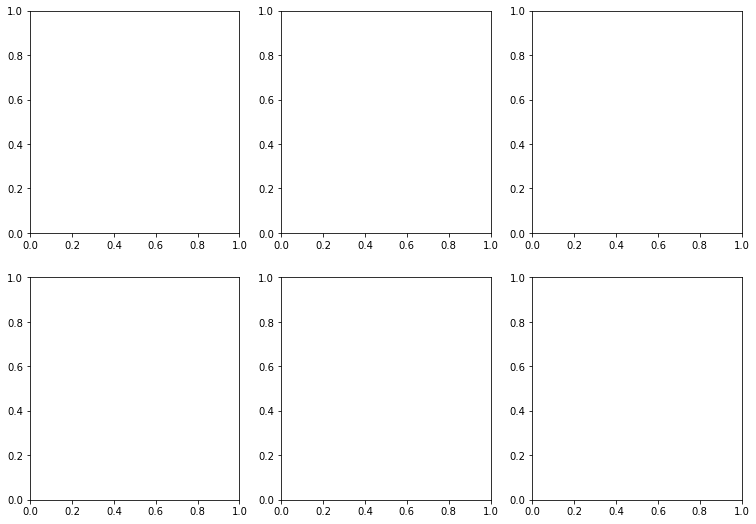

In [35]:
# hoursList = [9,12,15]
# fig,axs = plt.subplots(2,len(hoursList), figsize=(4.25*len(hoursList),9))
# axs = axs.ravel()

# caseSel1 = 'clubbMF'
# caseSel2 = 'clasp+MF'
# # caseSel1 = 'clubbMF_setSfcFlux'
# # caseSel2 = 'claspMF_setSfcFlux'

# # varSel   = 'edmf_upqt_interp' 
# # levVar   = 'levInterp'
# # longName = 'Plume updraft qt'

# varSel   = 'edmf_upthl_interp' 
# levVar   = 'levInterp'
# longName = 'Plume updraft thl'

# # varSel   = 'edmf_upw_interp' 
# # levVar   = 'levInterp'
# # longName = 'Plume updraft w'

# # varSel   = 'edmf_upbuoy_interp' 
# # levVar   = 'levInterp'
# # longName = 'Plume updraft buoyancy'

# # varSel   = 'edmf_updet_interp' 
# # levVar   = 'levInterp'
# # longName = 'Plume updraft detrainment'

# for iHour in range(len(hoursList)):
#     hourSel = hoursList[iHour]

#     for iEns in range(len(hourlyMeanSCAM.nens.values)):
#         ensSel1 = dsCtrl_Sel.sel(hour=hourSel).isel(lon=0,lat=0,nens=iEns)
#         ensSel2 = dsCLSP_Sel.sel(hour=hourSel).isel(lon=0,lat=0,nens=iEns)

#         axs[iHour].plot(ensSel1[varSel].values, ensSel1[levVar].values, label='Ens'+str(iEns+1))
#         axs[iHour+3].plot(ensSel2[varSel].values, ensSel2[levVar].values, label='Ens'+str(iEns+1))

#     if iHour==0:
#         axs[iHour].legend()
#         axs[iHour+3].legend()
    
#     axs[iHour].invert_yaxis()
#     axs[iHour+3].invert_yaxis()

#     axs[iHour].set_ylim([980,700])
#     axs[iHour+3].set_ylim([980,700])

#     axs[iHour].set_title(longName+'\nCaseName: '+caseSel1+'\nMean for hr '+str(hourSel))
#     axs[iHour+3].set_title('CaseName: '+caseSel2)

#     axs[iHour].grid()
#     axs[iHour+3].grid()

# # axs[2].axhline(925, linestyle='--')
# # axs[5].axhline(925, linestyle='--')

# # axs[5].set_ylim([980,920])
# # axs[5].set_xlim([220,320])

(1000.0, 900.0)

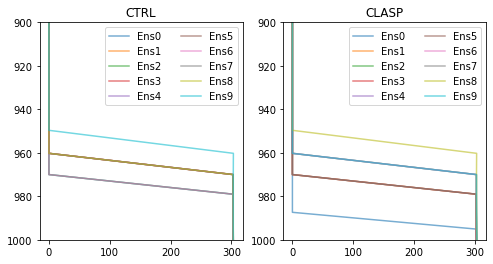

In [53]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
axs    = axs.ravel()

iMaskCTRL = np.where(caseCTRL.isel(lon=0,lat=0,time=410,nens = iEns).edmf_upthl.values==0)[0]
iMaskCLSP = np.where(caseCLSP.isel(lon=0,lat=0,time=410,nens = iEns).edmf_upthl.values==0)[0]

for iEns in range(len(caseCTRL.nens.values)):
    
    
    axs[0].plot(caseCTRL.isel(lon=0,lat=0,time=410,nens = iEns).edmf_upthl.values, 
                caseCTRL.isel(lon=0,lat=0,time=410,nens = iEns).ilev.values, 
                alpha = 0.6, label='Ens'+str(iEns))
    
    axs[1].plot(caseCLSP.isel(lon=0,lat=0,time=410,nens = iEns).edmf_upthl.values, 
                caseCLSP.isel(lon=0,lat=0,time=410,nens = iEns).ilev.values, 
                alpha = 0.6, label='Ens'+str(iEns))
    

axs[0].invert_yaxis()
axs[0].legend(ncol=2)
axs[0].set_title('CTRL')
axs[0].set_ylim([1000,900])

axs[1].invert_yaxis()
axs[1].legend(ncol=2)
axs[1].set_title('CLASP')
axs[1].set_ylim([1000,900])


In [36]:
caseCTRL.time.values[0]

numpy.datetime64('2018-06-05T05:01:00.000000000')

In [49]:
caseCTRL.time.values[410:415]

array(['2018-06-06T15:11:00.000000000', '2018-06-06T15:16:00.000000000',
       '2018-06-06T15:21:00.000000000', '2018-06-06T15:26:00.000000000',
       '2018-06-06T15:31:00.000000000'], dtype='datetime64[ns]')